## Econ 570 Final Project
## Predict Medical Costs based on Personal Characteristics

#### *Group Members:  Feng Cheng (6061910560), Jiachen Zhang (4703851532), Ziruo Zhao (7912734551)*

The objective of this project is to predict the medical costs based on the characteristics of each person. 

This project is organized in the following sections:

* **Section 1** - Introduction 
* **Section 2** - Data Processing
* **Section 3** - Modeling
* **Section 4** - Findings
* **Section 5** - Conclusions

## **Section 1**  - Introduction

**What question are you answering with your project?**

The objective of this project is to predict the medical costs based on the characteristics of each person. In this project, our team is trying to answer whether people’s Body Mass Index (BMI), age, and smoking behavior can be used to predict their medical cost. BMI is a measure of body fat, it equals to a person’s weight in kilograms (or pounds) divided by the square of height in meters (or feet).

**Why should we care about this question?**

Knowing how much medical cost would be will help people better choose appropriate health insurance. People will then have a basic idea on how much they should spend on health coverages based on their personal information. They have less chance to underestimate how much medical costs can be.


**Have there been previous papers in the economics literature addressing this question? Summarize previous research briefly.**

There is one published article online called “Association of body mass index with health care expenditures in the United States by age and sex”, written by Zachary J. Ward, Sara N. Bleich, Michael W. Long and Steven L. Gortmaker, has discussed the relationship between medical cost and BMI, age and gender. 
In the paper, authors used data from the Medical Expenditure Panel Survey (MEPS) from 2011 to 2016 to estimate continuous BMI-related health care expenditures. They have collected 175,726 respondents’ data in total. 
They used generalized additive models to estimate the relationship between log BMI and the log of the standardized expenditures using a two-part model. They found that BMI has a significant positive correlation with health care expenditures. People who have a higher BMI would face higher health care costs: over 30 units of BMI, each one-unit BMI increase was associated with an additional cost of $253 per person. 


## **Section 2**  - Data Processing

This project used a public dataset “medical cost personal datasets” from Kaggle, created by Miri Choi. But the data is originally used in the book Machine Learning with R by Brett Lantz. All of the datasets are now in the public domain but simply got cleaned up and recorded to match the format in the book. This medical cost personal datasets contain data of people’s medical insurance cost and their personal characteristics, such as age, sex, bmi and smoking behavior etc.

In [103]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [104]:
# Getting the data
df = pd.read_csv('insurance.csv')

In [105]:
# Show the first five rows of the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [107]:
# Separate of numerical columns and categorical columns
cat_col = df.select_dtypes(include=['object']).columns
num_col = df.select_dtypes(exclude=['object']).columns
df_cat = df[cat_col]
df_num = df[num_col]

In [108]:
# Checking if there is any null value in the dataset
df_null = df.isna().mean()
df_null.sort_values(ascending = False)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

There aren't null values in the dataset.

(1338, 7)

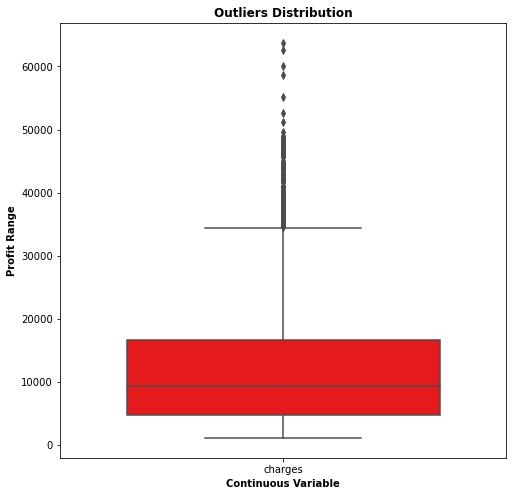

In [109]:
# Checking if there are any outliers
outliers = ['charges']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Distribution", fontsize = 12, fontweight = 'bold')
plt.ylabel("Profit Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')
df.shape

Based on 1.5 deviation from quartiles, there are a lot of outliers. We choose to check the number of the outliners first.

In [110]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3 - q1
df_outliers_sum = ((df['charges'] < (q1 - 1.5 * iqr)) | (df['charges'] > (q3 + 1.5 * iqr))).sum()
print(df_outliers_sum)

139


So there are 139 outliers values, which represents about 10% of all population. 
We choose not to remove them because they are not so different from the average values and they probably are a natual part of the population we are studying.

In [111]:
# Checking if there are any duplicated values
df.loc[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


There is one duplicated value, so it will be removed.

In [112]:
#dropping duplicated value
df.drop(581)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Visualizing data by column

Text(0, 0.5, 'Count')

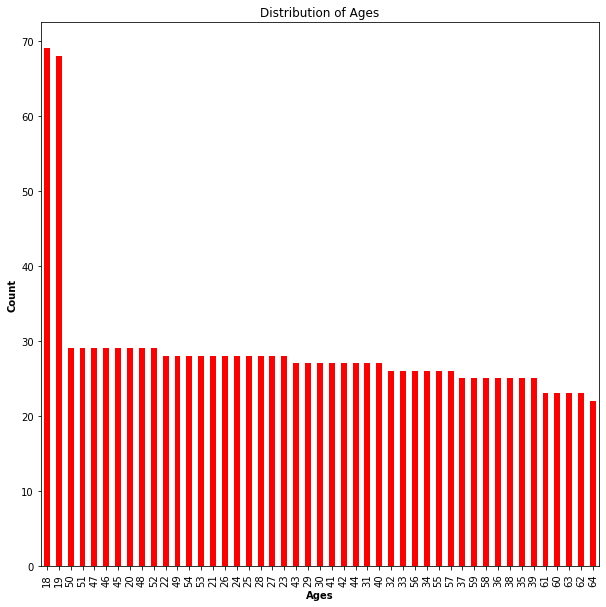

In [113]:
#Visualizing the age column
plt.rcParams['figure.figsize'] = [10,10]
ax=df['age'].value_counts().plot(kind='bar',stacked=True, color= "red")
ax.title.set_text('Distribution of Ages')
plt.xlabel("Ages",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')

summary:
- The proportion of 18 and 19 years old people is almost the double of the other ages;
- Except by the ages of 18 and 19, the proportion of ages is very regular.

Text(0, 0.5, 'Count')

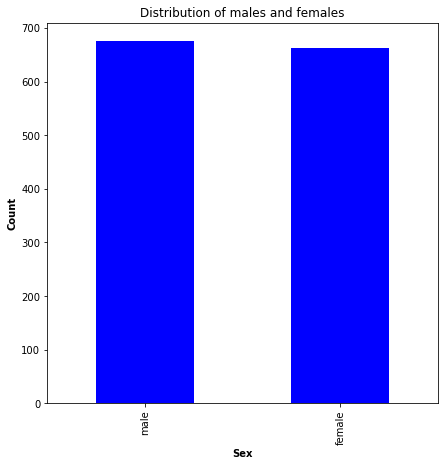

In [114]:
# Analyzing the sex column
plt.rcParams['figure.figsize'] = [7,7]
ax=df['sex'].value_counts().plot(kind='bar',stacked=True, color= "blue")
ax.title.set_text('Distribution of males and females')
plt.xlabel("Sex",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')

summary:
- There is almost the same number of males and females people

<AxesSubplot:title={'center':'BMI Distribution'}, xlabel='bmi', ylabel='Count'>

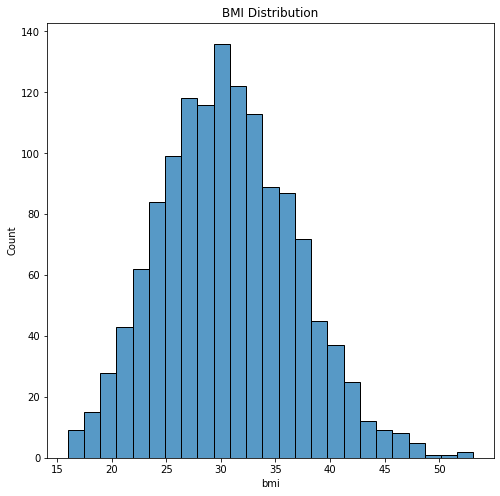

In [115]:
# Visualizing the distribution of bmi
plt.figure(figsize=(8,8))

plt.title('BMI Distribution')
sns.histplot(df['bmi'])

summary:
- This curve is very similar to a normal distribution and very simetric also;
- The mean of this bmi population seems to be around 30.

Text(0, 0.5, 'Count')

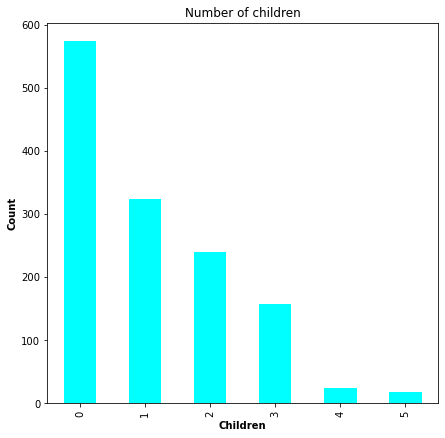

In [116]:
# Analyzing the children column
plt.rcParams['figure.figsize'] = [7,7]
ax=df['children'].value_counts().plot(kind='bar',stacked=True, color= "aqua")
ax.title.set_text('Number of children')
plt.xlabel("Children",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')

summary:
- Most of the people doesn't have children

Text(0, 0.5, 'Count')

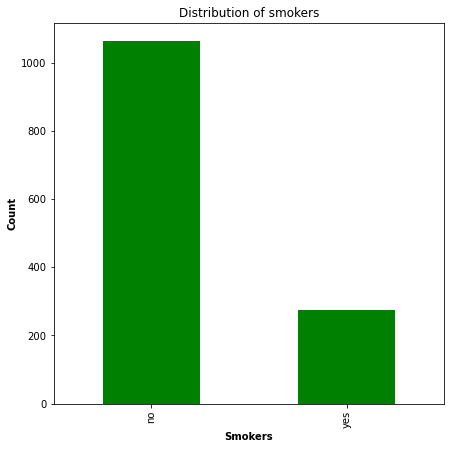

In [117]:
# Analyzing the smoker column
plt.rcParams['figure.figsize'] = [7,7]
ax=df['smoker'].value_counts().plot(kind='bar',stacked=True, color= "green")
ax.title.set_text('Distribution of smokers')
plt.xlabel("Smokers",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')

summary:
* Most of the people don't smoke

Text(0, 0.5, 'Count')

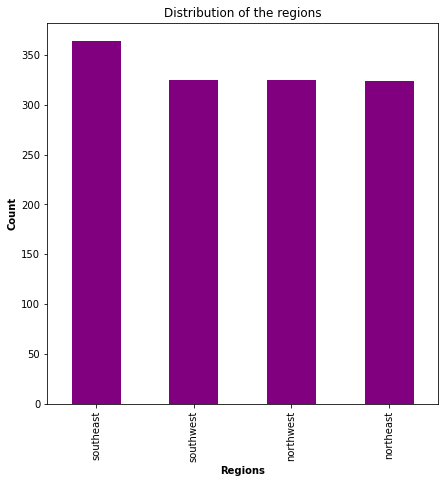

In [118]:
# Analyzing the region column
plt.rcParams['figure.figsize'] = [7,7]
ax=df['region'].value_counts().plot(kind='bar',stacked=True, color= "purple")
ax.title.set_text('Distribution of the regions')
plt.xlabel("Regions",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')

summary:
* It seems very regular the distribution of the regions where the people live

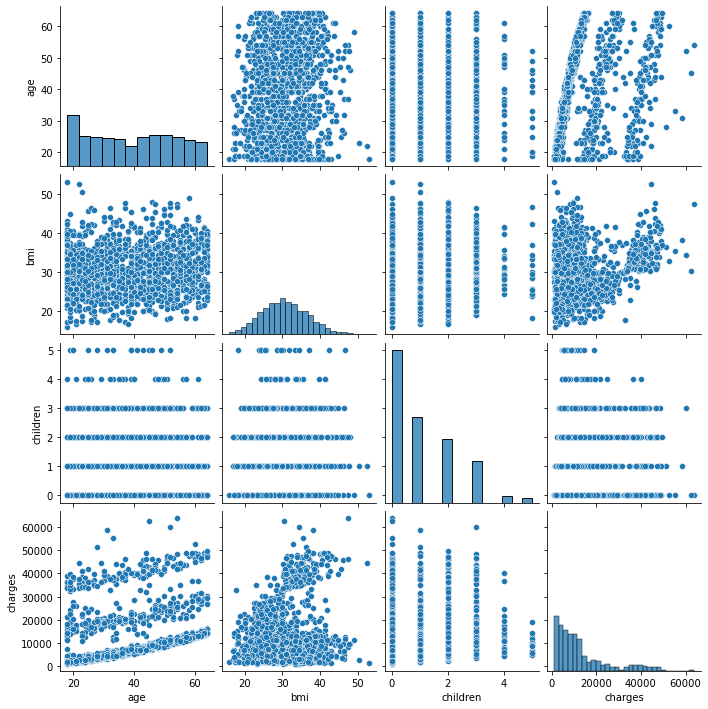

In [119]:
dist = sns.pairplot(df[num_col])

Insights:
* The number of children seems to have poor correlation with the medical costs;
* The age of the person and its BMI have little correlation.

In [120]:
df_corr = df.copy()
df_corr['sex'] = pd.factorize(df_corr['sex'])[0] + 1
df_corr['region'] = pd.factorize(df_corr['region'])[0] + 1
df_corr['smoker'] = pd.factorize(df_corr['smoker'])[0] + 1
corr = df_corr.corr()
corr['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region      0.006208
smoker     -0.787251
Name: charges, dtype: float64

Summarize:
* As we observe, the number of children, sex and region has poor correlation, so they will be dropped from the model;
* The smoker column has a strong inverse correlation with the medical costs.

### Data Transformation

#### Dropping the columns
As verified earlier, the children, sex and region columns have a poor correlation with the charges column, so they will be removed from our model.

In [121]:
df = df.drop(['children', 'sex', 'region'], axis = 1)

#### Convert the categorical data

In [122]:
#transforming the categorical value
df['smoker'] = pd.factorize(df['smoker'])[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      1338 non-null   int64  
 1   bmi      1338 non-null   float64
 2   smoker   1338 non-null   int64  
 3   charges  1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


## **Section 3** -  Modeling

In this project, we use four models to predict medical costs. Firstly, we used OLS regression and explore the cases of controlling for covariates and not controlling for covariates. Then we used other two complicated models to make prediction. We refer to two literatures. Kuo et. al.(2018) compared several machine learning algorithms for prediction of medical costs. This article mainly discussed the classification problem. We tried several methods, and according to the model performance, we decided to use random forest. In addition, we also learned from an article related to ensemble methods. Shakhovska et. al.(2021) studied ensemble methods for medical insurance costs prediction. The ensemble methods is an important module in python *sklearn*. Referring to the statistical results of the article, we chose the stacking method. The stacking regressor is developed using Ridge Regression and Support Vector Regression (SVR). The random forest (RF) algorithm is used to combine the predictions. To evaluate the accuracy of models, we used R squared score, root mean squared error (RMSE), mean absolute error (MAE), and mean absolute percentage error (MAPE).

#### Get the dependent and independent variables

In [123]:
#Separate the dependent and independent values
y = df.loc[:, ['charges']].values
X = df.drop(columns=['charges'])

### 3.1 OLS Model - Control for covariates

In [124]:
from statsmodels.formula.api import ols
fit = ols('charges ~ C(smoker) + bmi + age', data=df).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1316.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        17:39:31   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1334   BIC:                         2.714e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.215e+04    987.085     12.306      0.000    1.02e+04    1.41e+04
C(smoker)[T.1] -2.382e+04    412.867    -57.703      0.000   -2.46e+04    -2.3e+04
bmi              322.6151     27.487     11.737      0.000     268.692     376.538
age              259.5475     11.934     21.748      0.000     236.136     282.959
==============================================================================
Omnibus:                      299.709   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.137
Skew:                           1.213   Prob(JB):                    6.25e-155
Kurtosis:                       5.618   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  Get the train and test data set

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Fit the Linear Regression Model

In [126]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
regressor = LinearRegression()
# fitting the training data
regressor.fit(X_train,y_train)

LinearRegression()

#### Make prediction

In [127]:
y_pred1 = regressor.predict(X_test)

#### Evaluate accuracy

In [157]:
# Evaluating the accuracy score
print('r2 socre =',r2_score(y_test,y_pred1))
print('RMSE =',np.sqrt(mean_squared_error(y_test,y_pred1)))
print('MAE =',mean_absolute_error(y_test,y_pred1))
print('MAPE =',mean_absolute_percentage_error(y_test,y_pred1))

r2 socre = 0.7945500805653086
RMSE = 5717.800096079452
MAE = 3960.866619808715
MAPE = 0.41079051705728437


In [129]:
regressor.coef_

array([[   257.04066602,    321.83997719, -23625.23448834]])

In [130]:
regressor.intercept_

array([12053.3264715])

**Creating a label to show the equations**:

$ x_{1} $ = Age

$ x_{2} $ = BMI

$d$ = Dummy variable to represent if the person is a smoker (inverted the signal to be easier to interpret)

$y$ = Medical charges

So, the equation is:

$y = 12053.33 + 257.04x_{1} + 321.84x_{2} + 23625.23d$

### 3.2 OLS Model - Do not control for covariates

In [131]:
df1 = df.drop(['age'], axis = 1)
df1

,bmi,smoker,charges
0,27.900,0,16884.92400
1,33.770,1,1725.55230
2,33.000,1,4449.46200
3,22.705,1,21984.47061
4,28.880,1,3866.85520
...,...,...,...
1333,30.970,1,10600.54830
1334,31.920,1,2205.98080
1335,36.850,1,1629.83350
1336,25.800,1,2007.94500


In [132]:
y = df1.loc[:, ['charges']].values
X1 = df1.drop(columns=['charges'])

In [133]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 0)

In [134]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X1_train,y_train)

LinearRegression()

In [135]:
y_pred2 =  LR.predict(X1_test)

In [158]:
# predicting the accuracy score
print('r2 socre =',r2_score(y_test,y_pred2))
print('RMSE =',np.sqrt(mean_squared_error(y_test,y_pred2)))
print('MAE =',mean_absolute_error(y_test,y_pred2))
print('MAPE =',mean_absolute_percentage_error(y_test,y_pred2))

r2 socre = 0.705918476607126
RMSE = 6840.846565823658
MAE = 5213.98544168031
MAPE = 0.8084366400697199


In [137]:
LR.coef_

array([[   386.94616325, -23187.3567059 ]])

In [138]:
LR.intercept_

array([19752.61188429])

In [139]:
# Visualizing once again the data set
df.head()

,age,bmi,smoker,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,1,4449.46200
3,33,22.705,1,21984.47061
4,32,28.880,1,3866.85520


**Creating a label to show the equations**:

$ x_{1} $ = BMI

$d$ = Dummy variable to represent if the person is a smoker (inverted the signal to be easier to interpret)

$y$ = Medical charges

So, the equation is:

$y = 19752.61 + 386.95 x_{1} + 23187.35d$

### 3.3 Random Forest

In [140]:
#Separate the dependent and independent values
y = df.loc[:, ['charges']].values
X = df.drop(columns=['charges'])
#Get the train and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [141]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/var/folders/bx/6bx3kxkj3h1cz3k5xxlrgfj80000gn/T/ipykernel_1672/3300557753.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor()

In [142]:
y_pred3 = rf.predict(X_test)

In [143]:
# predicting the accuracy score
print('r2 socre =',r2_score(y_test,y_pred3))
print('RMSE =',np.sqrt(mean_squared_error(y_test,y_pred3)))
print('MAE =',mean_absolute_error(y_test,y_pred3))
print('MAPE =',mean_absolute_percentage_error(y_test,y_pred3))

r2 socre = 0.8566196063999679
RMSE = 4776.621884899897
MAE = 2757.58610206617
MAPE = 0.38839749953193725


### 3.4 Stacking

In [144]:
#Separate the dependent and independent values
y = df.loc[:, ['charges']].values
X = df.drop(columns=['charges'])
#Get the train and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [152]:
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
estimators = [('lr', Ridge()), ('svr', LinearSVR())]
stacking = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())
stacking.fit(X_train, y_train)

/Users/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py:754: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('lr', Ridge()), ('svr', LinearSVR())],
                  final_estimator=RandomForestRegressor())

In [153]:
y_pred4 = stacking.predict(X_test)

In [154]:
# predicting the accuracy score
print('r2 socre =',r2_score(y_test,y_pred4))
print('RMSE =',np.sqrt(mean_squared_error(y_test,y_pred4)))
print('MAE =',mean_absolute_error(y_test,y_pred4))
print('MAPE =',mean_absolute_percentage_error(y_test,y_pred4))

r2 socre = 0.8578751154421188
RMSE = 4755.662679872499
MAE = 2748.9020366797254
MAPE = 0.334311073961447


## **Section 4** - Findings

#### Make a table of accuracy indicators

In [156]:
r2 = []
rmse = []
mae = []
mape = []
y_pred = [y_pred1, y_pred2, y_pred3, y_pred4]

for i in range(4):
    r2.append(round(r2_score(y_test,y_pred[i]),8))
    rmse.append(round(np.sqrt(mean_squared_error(y_test,y_pred[i])),8))
    mae.append(round(mean_absolute_error(y_test,y_pred[i]),8))
    mape.append(round(mean_absolute_percentage_error(y_test,y_pred[i]),8))

name = ["OLS-Control for covariates","OLS-Do not control for covariates","Random Forest","Stacking"]
measure = ["R-squared", "RMSE", "MAE", "MAPE"]
data = np.array([r2,rmse,mae,mape]).T.tolist()
pd.DataFrame(data, columns = measure, index = name)

,R-squared,RMSE,MAE,MAPE
OLS-Control for covariates,0.794550,5717.800096,3960.866620,0.410791
OLS-Do not control for covariates,0.705918,6840.846566,5213.985442,0.808437
Random Forest,0.856620,4776.621885,2757.586102,0.388398
Stacking,0.857875,4755.662680,2748.902037,0.334311


At first, we used two ols models to predict medical costs. For first model, we controlled for covariates, and for the second model, we did not control for covariate "age". R-squared is a number of systematic variation over total variation, which is used to measure the accuracy of models. R-squared is larger than 0.7, which indicates the fit of model is good. The model that we control for covariates was more accurate, which has a higher R-squared score. According to the results, we found that smokers have more medical costs compared with the non-smoking group. For BMI, the higher BMI, the higher medical costs. Whether the person is smoker has a higher impact on medical costs, compared with BMI. Our findings are robust to the two different model specifications. In the first model, we added a covariate "age". Older people tend to have higher medical costs. Comparing the variables age and BMI, BMI has a higher impact on medical charges.

In addition, we used two other regressors of random Forest and stacking. Comparing the R-squared score, RMSE, MAE and MAPE, it is clear that random forest model has a much better performance than the first OLS model. The last model using stacking regressor made a little improvement compared with the random forest model, the R-squared score is closer to 1, and RMSE and MAE have decreased.

## **Section 5** - Conclusion

We conducted data analysis and build models to predict the medical cost in this project.  We focused on the main factors including BMI and whether the person is a smoker. The result shows that smoking and high BMI can lead to higher medical cost. Smoking has an adverse effect on human health. In the dataset we used, no samples had BMI values below 15. From the results of data analysis, the problem of high BMI is more obvious. Obesity and overweight can also lead to health problems. The results of the models are consistent with the facts in reality.

For further research, the impact of smoking and BMI on medical expenses can be further investigated . For example, for smoking status, the weekly smoking volume of the sample needs to be collected to replace the current dummy variable. For BMI, as mentioned above, there are no samples with low BMI in this data set. In the follow-up study, the situation of low BMI can be further analyzed. In addition, BMI of a person can easily change, since the change of eating habits and exercise habits will greatly affect BMI. We can explore whether the change of BMI will have a significant impact on the medical cost, for example, whether the group with high BMI will be able to significantly reduce their medical cost after losing weight.

## References

Shakhovska, Melnykova, N., Chopiyak, V., & Gregus Ml, M. (2022). An ensemble methods for medical insurance costs prediction task. Computers, Materials & Continua, 70(2), 3969–3984. https://doi.org/10.32604/cmc.2022.019882

Kuo, Yu, L.-C., Chen, H.-C., & Chan, C.-L. (2018). Comparison of models for the prediction of medical costs of spinal fusion in Taiwan diagnosis-related groups by machine learning algorithms. Healthcare Informatics Research, 24(1), 29–37. https://doi.org/10.4258/hir.2018.24.1.29